## Offline RL
<!-- video shot="/eOFzSon7dK0" start="39:35" end="51:03" -->

In [1]:
# HIDDEN
import gym
import numpy as np

In [2]:
# HIDDEN
import ray
import logging
ray.init(log_to_driver=False, ignore_reinit_error=True, logging_level=logging.ERROR) # logging.FATAL

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#### Is this realistic?

- So far we've built a simulation of user behavior
- In some applications, we may be able to build accurate simulations:
  - physics simulations (e.g. robots)
  - games
  - economic/financial simulations?
- However, for user behavior, this is hard

#### Is this realistic? 

- Best would be to deploy RL live, but not practical
- Another possibility: learn from user data?
- We can do this with **offline reinforcement learning**

#### Offline RL

- What is offline RL?
- Recall our RL loop:

![](img/RL-loop-3.png)

#### Offline RL

- In offline RL we don't have an environment to interact with in a feedback loop:

![](img/offline-RL-loop.png)

This historic data was generated by some other, unknown policy/policies.

Notes:

Could be generate by real users, or by a different source (random, or RL agent!)

#### Challenge of offline RL

- Can't answer "what if" questions
- We can only see the results of actions attempted in the dataset

Notes:

Perhaps this makes us appreciate how valuable/awesome it is to actually have an env available, which we have had for all the rest of the course. It allows us to try anything with no cost except computational cost (assuming it's a simulator, not a real world environment). 

In [3]:
# # HIDDEN

# # generate the offline dataset
# env_config = {
#     "num_candidates" : 2,
#     "alpha"          : 0.5,
#     "seed"           : 42
# }

# from ray.rllib.algorithms.ppo import PPO, PPOConfig

# ppo_config = (
#     PPOConfig()\
#     .framework("torch")\
#     # need to set num_rollout_workers=1 for now per https://github.com/ray-project/ray/issues/25696
#     .rollouts(create_env_on_local_worker=True, num_rollout_workers=1)\
#     .debugging(seed=0, log_level="ERROR")\
#     .training(model={"fcnet_hiddens" : [64, 64]}, lr=0.001)\
#     # .environment(env_config=env_config)\
#     .offline_data(output="data/recommender2")
# )

# from envs import BasicRecommenderWithHistory

# ppo_history = ppo_config.build(env="CartPole-v1")

# rewards_history = []
# for i in range(25):
#     result = ppo_history.train()
#     rewards_history.append(result["episode_reward_mean"])
    
# ppo_history.evaluate(duration_fn=1000)["evaluation"]["episode_reward_mean"]

#### Recommender dataset

- Let's explore an offline dataset that we can learn from.
- We'll need a bit of code to read all the JSON objects in the file:

In [4]:
import json

json_dataset_file = "data/recommender_offline.json"

rollouts = []
with open(json_dataset_file, "r") as f:
    for line in f:
        data = json.loads(line)
        rollouts.append(data)

In [5]:
len(rollouts)

50

We have 50 "rollouts" of data.

Notes:

The file is in the format that RLlib learns from.

#### Recommender dataset

Each rollout is a dict containing info about the time step:

In [6]:
from ray.rllib.utils.compression import unpack

obs = unpack(rollouts[0]["obs"])
obs.shape

(200, 2)

- We have 200 time steps worth of data in each rollout
- Let's look at the observations first

Notes:

This number 200 is set by the "rollout_fragment_length" algorithm config parameter.

#### Recommender dataset

Here are the first 3 observations:

In [7]:
obs[:3]

array([[0.6545137 , 0.29728338],
       [0.5238871 , 0.5144319 ],
       [0.6741674 , 0.10163702]], dtype=float32)


We can see `num_candidates` was set as 2

#### Recommender dataset

We can also look at the first 3 actions, rewards, dones:

In [8]:
rollouts[0]["actions"][:3]

[0, 0, 1]

In [9]:
rollouts[0]["rewards"][:3]

[0.6545137166976929, 0.3524414300918579, 0.05838315561413765]

In [10]:
rollouts[0]["dones"][:3]

[False, False, False]

Notes:

So, first the agent saw the observation [0.65, 0.297] from the previous slide, then it took action 0, got a reward of 0.65, and the episode was not done.

There is more information stored in the dataset than just the above, but these are the key points.

#### Supervised learning

- Wait, this is a dataset... can't we just do supervised learning to map states to actions? 🤔
- Yes, we can, and this would aim to recover the policy that generated the dataset (_imitation learning_).
- But it is actually possible to do _better_... and that is our goal with offline RL.

In [11]:
# TODO
# maybe going overboard here, but for a synthetic example we could actually show it does better than the policy that generated the data,
# since we generated the data ourselves

#### Offline RL training

- Lots of info on offline RL with RLlib [here](https://docs.ray.io/en/latest/rllib/rllib-offline.html).
- First we need an algorithm.
- For offline RL we can't use `PPO`.
- We'll use the `MARWIL` algorithm that is included with RLlib.

In [12]:
from ray.rllib.algorithms.marwil import MARWILConfig

#### Offline RL training

Next, we create the config, starting with `MARWILConfig` instead of `PPOConfig`

In [13]:
# This is the same as before
offline_config = ( 
    MARWILConfig()
    .framework("torch")
    .rollouts(create_env_on_local_worker=True)
    .debugging(seed=0, log_level="ERROR")
    .training(model={"fcnet_hiddens" : [64, 64]})
)

# This is new for offline RL
num_candidates = 2
offline_config = offline_config.environment(
    observation_space = gym.spaces.Box(low=0, high=1, shape=(num_candidates,)), 
    action_space = gym.spaces.Discrete(num_candidates),
).offline_data(
    input_ = [json_dataset_file],
)

Notes:

- The config items on the top should look familiar. On the second half, things are a bit different:
  - We need to give it the path to the dataset file
  - Because there is no env, we need to manually specify the observation and action spaces
- We don't have an environment config because there is no environment!

#### Training

In [14]:
marwil = offline_config.build()

In [15]:
for i in range(50):
    marwil.train()

#### Evaluation

_How do we evaluate without a simulator?_

- This is called off-policy estimation.
- It's a more sophisticated technique and outside the scope of this course.
- See the RLlib docs [here](https://docs.ray.io/en/latest/rllib/rllib-offline.html).
- What we'll do is evaluate with our simulator, since we do have it.

Notes:

In a realistic offline RL scenario, you don't have a simulator available. Then you need to use some more complex evaluation techniques called off-policy estimation. You would have train/test data sets like in supervised learning. 

For our purposes though, since we do have a simulator, we'll make use of them for evaluation. RLlib actually has an option to allow this, because it is useful for debugging and such. We'll see that on the next slide.

#### Evaluation with our simulator

We can evaluate the algorithm using our env simulator.

In [16]:
# HIDDEN
from envs import BasicRecommender

env_config = {
    "num_candidates" : 2,
    "alpha"          : 0.5,
    "seed"           : 42
}

In [17]:
env = BasicRecommender(env_config)

def get_episode_reward(env, algo):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = algo.compute_single_action(obs)
        obs, reward, done, _ = env.step(action)
        total_reward += reward
    return total_reward

- Above: set up a function that runs one episode with the simulator.
- Below: run this for 100 episodes to get the mean.

In [18]:
np.mean([get_episode_reward(env, marwil) for i in range(100)])

25.537665635536726

This seems to be doing about the same as random again (25.5).

#### RLlib for simulator-based evaluation

RLlib also offers this as a feature:

In [31]:
offline_config = offline_config.evaluation(
    off_policy_estimation_methods={},
    evaluation_config={
        "input": "sampler",
        "env": BasicRecommender,
        "env_config" : env_config
    }
)

In [ ]:
# HIDDEN
#marwil.stop()

If we had set up the config this way and trained:

In [32]:
marwil = offline_config.build()

In [33]:
for i in range(10):
    marwil.train()

In [30]:
marwil.evaluate()["evaluation"]["episode_reward_mean"]

25.3457144503546

Here we again see a similar result.

#### Let's apply what we learned!

## Example of offline RL
<!-- multiple choice -->

- [ ] Teaching an AI to play chess by having it play against other AIs repeatedly.
- [x] Teaching an AI to play chess based on past games by professional chess players.

## Does offline data help?
<!-- multiple choice -->

Imagine you have an env that perfectly represents your environment; for example, maybe you are training an AI to play a single-player game like [Atari Breakout](https://en.wikipedia.org/wiki/Breakout_(video_game)). In addition to the simulator, you also have some offline data available. Though not discussed in the above slides, it is possible to mix a simulator with offline data to jointly train an agent using RL (see [here](https://docs.ray.io/en/latest/rllib/rllib-offline.html#mixing-simulation-and-offline-data)). If you already have a perfect simulator, could offline data provide any additional utility, if combined with the simulator during training?

#### Best policy after training

Choose the correct statement regarding finding the best policy after unlimited training. You can assume you have a 'perfect' RL algorithm, meaning it can represent any policy and is able to optimize any function.

- [x] With a 'perfect' RL algorithm and enough compute time, there is no benefit to using the historical data because the simulator contains everything there is to know about the environment.
- [ ] With a 'perfect' RL algorithm and unlimited compute time, the historical data may help you find a better policy than only using the simulator. | With a 'perfect' RL algorithm, you should eventually find the optimal policy. This is like having infinite data, infinite compute time, an arbitrarily complex model, and a perfect optimization method.

#### Training speed

Choose the correct statement regarding finding the best policy after a bit of training. You can assume you have a 'perfect' RL algorithm, meaning it can represent any policy and is able to optimize any function.

- [ ] With a 'perfect' RL algorithm but only a bit of compute time, there is no benefit to using the historical data because the simulator contains everything there is to know about the environment. | What if the historical data was generated using the *optimal* policy?
- [x] With a 'perfect' RL algorithm but only a bit of compute time, the historical data may help you find a better policy than only using the simulator. | If the historical data was generated using a very good policy, you could learn from it quickly.

## Historical data policy
<!-- multiple choice -->

Offline RL relies on data generated by some policy interacting with the environment. Which of the following is **NOT** a desirable property of this dataset / historical policy?
 
- [x] The environment and the historical policy are both deterministic. | In this case, we would only explore one trajectory through the environment. 
- [ ] The dataset contains a large number of episodes.
- [ ] The historical policy explores a variety of states in the environment.
- [ ] The historical policy achieves high reward in some episodes.   

In [1]:
# HIDDEN
# ## Offline RL for Cartpole
# <!-- coding exercise -->

# In this exercise we'll tackle the famous [Cartpole benchmark problem](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) that is bundled with the `gym` library. The goal is to keep the inverted pendulum from falling over by applying force, either left or right, at each time step. 

# We will train the agent using offline data contained in a file `cartpolev1_offline.json` that is read in by the code.

# We will _evaluate_ the agent using the real Cartpole simulator. (Again, in reality, if we were using offline RL we probably wouldn't have access to the real simulator, but we're including it here so that we can do ground-truth evaluation of our agent.)

# Fill in the missing code. Then, run the code and answer the multiple-choice question below.

In [31]:
# HIDDEN
# EXERCISE
import gym
import numpy as np
import matplotlib.pyplot as plt

from ray.rllib.algorithms.marwil import MARWIL, MARWILConfig

offline_trainer_config = {
    # These should look familiar:
    "framework"             : "torch",
    "create_env_on_driver"  : True,
    "seed"                  : 0,
    "model"                 : {
        "fcnet_hiddens"     : [64, 64]
    },
    
    # These are new for offline RL:
    ____: ["data/cartpolev1_offline.json"],
    "observation_space": gym.spaces.Box(low=____, 
                                        high=np.array([4.8,  np.inf,  0.42,  np.inf])),
    "action_space": gym.spaces.Discrete(2),
    "input_evaluation" : ["simulation", "is", "wis"],
    "env" : "CartPole-v1" # for evaluation only
}

algo = ____

# Training (and storing results)
results_off = []
results_sim = []
for i in range(200):
    r = algo.____()
    results_off.append(r["off_policy_estimator"]["wis"]['V_gain_est'])
    results_sim.append(r["episode_reward_mean"])

plt.plot(results_sim);
plt.xlabel('iterations') 
plt.ylabel('simulator reward')

algo.stop()

NameError: name '____' is not defined

/Users/mike/miniconda3/envs/ray200/lib/python3.9/site-packages/ray/rllib/utils/debug/deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):
/Users/mike/miniconda3/envs/ray200/lib/python3.9/site-packages/ray/_private/ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(


0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'simulator reward')

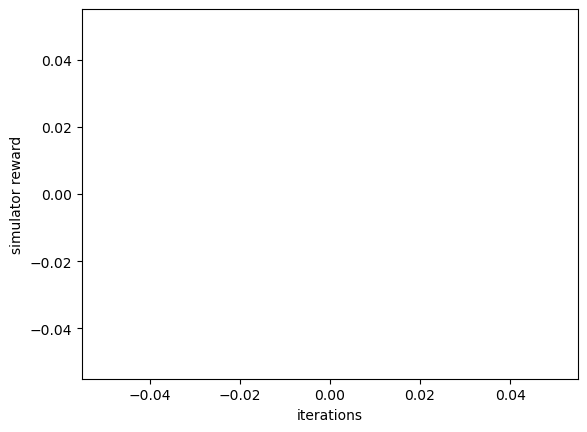

In [32]:
# HIDDEN
# SOLUTION
import gym
import numpy as np
import matplotlib.pyplot as plt
from ray.rllib.algorithms.marwil import MARWILConfig

# This is the same as before
offline_config = ( 
    MARWILConfig()
    .framework("torch")
    .rollouts(create_env_on_local_worker=True)
    .debugging(seed=0, log_level="ERROR")
    .training(model={"fcnet_hiddens" : [32, 32]})
)
# This is new for offline RL
offline_config = offline_config.environment(
    observation_space = gym.spaces.Box(low=np.array([-4.8, -np.inf, -0.42, -np.inf]), 
                                        high=np.array([4.8,  np.inf,  0.42,  np.inf])),
    action_space = gym.spaces.Discrete(2)
).offline_data(
    input_ = ["data/cartpolev1_offline.json"]
).evaluation(
    off_policy_estimation_methods={},
    evaluation_config={
        "input": "sampler",
        "env": "CartPole-v1",
    }
)

algo = offline_config.build()

# Training (and storing results)
results = []
for i in range(10):
    print(i)
    r = algo.train()
    results.append(r["episode_reward_mean"])

plt.plot(results)
plt.xlabel('iterations') 
plt.ylabel('simulator reward') 

# algo.stop()

In [31]:
# TODO
# see the tuned examples here: https://docs.ray.io/en/master/rllib/rllib-algorithms.html#offline

In [ ]:
# TODO:
# - ALSO: this might be a great example to try supervised learning and show why it doesn't work...???
#   - in some ways this is a way better example than frozen lake... because there IS a short-term reward, it's just not what you should look at.
#   - with frozen lake there is no short-term reward, so RL seems "obvious"
# Or, that could go in the offline RL section, since we already have a data file there and could do SL directly on it
# Yes, that seems cool.
# could use scipy/numpy to just do the normal equations if we want to avoid adding a dependency on sklearn 

# Supervised learning only gives you imitation learning, which can only get as good as the policy that generated the data